In [1]:
import pandas as pd
import numpy as np
import operator
import os
import warnings
import random
import imageio
import glob
import scipy
import torch
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from sklearn import metrics
from skimage.transform import resize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
random.seed(20)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
csvs

['../Stanford_MIT_CHEST/CheXpert-v1.0/test-set-labels/radiologists/benchmark_radiologists/bc4.csv',
 '../Stanford_MIT_CHEST/CheXpert-v1.0/test-set-labels/radiologists/benchmark_radiologists/bc6.csv',
 '../Stanford_MIT_CHEST/CheXpert-v1.0/test-set-labels/radiologists/benchmark_radiologists/bc8.csv']

In [8]:
df_bc6

,Study,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/test/patient64741/study1,0,1,1,0,1,0,0,0,1,0,0,0,0,1
1,CheXpert-v1.0/test/patient64742/study1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,CheXpert-v1.0/test/patient64743/study1,0,1,1,0,1,0,1,0,1,0,1,0,0,0
3,CheXpert-v1.0/test/patient64744/study1,0,1,1,0,1,0,0,0,1,0,0,0,0,1
4,CheXpert-v1.0/test/patient64745/study1,0,1,1,1,1,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CheXpert-v1.0/test/patient65236/study1,0,1,1,0,1,1,0,0,0,0,0,0,0,1
496,CheXpert-v1.0/test/patient65237/study1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
497,CheXpert-v1.0/test/patient65238/study1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
498,CheXpert-v1.0/test/patient65239/study1,0,1,1,0,1,1,0,0,1,0,0,0,0,1


In [11]:
df_truth = pd.read_csv('../Stanford_MIT_CHEST/CheXpert-v1.0/test-set-labels/groundtruth.csv')

csv_path = '../Stanford_MIT_CHEST/CheXpert-v1.0/test-set-labels/radiologists/benchmark_radiologists'
csvs = sorted(glob.glob(os.path.join(csv_path, '*.csv')))
#df_expert = pd.read_csv(csvs[2])
#(df_expert['Study'] == df_truth['Study']).sum()
PRED_LABEL = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 
            'Lung Opacity', 'Lung Lesion', 'Edema', 
            'Consolidation', 'Pneumonia', 'Atelectasis',
            'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 
            'Fracture', 'Support Devices']

bc4 = defaultdict(list)
bc6 = defaultdict(list)
bc8 = defaultdict(list)
df_bc4 = pd.read_csv(csvs[0])
df_bc6 = pd.read_csv(csvs[1])
df_bc8 = pd.read_csv(csvs[2])
for patho in PRED_LABEL:
    y_truth = df_truth[patho]
    y_bc4 = df_bc4[patho]
    y_bc6 = df_bc6[patho] 
    y_bc8 = df_bc8[patho] 
    
    tn_4, fp_4, fn_4, tp_4 = confusion_matrix(y_truth, y_bc4).ravel()
    tn_6, fp_6, fn_6, tp_6 = confusion_matrix(y_truth, y_bc6).ravel()
    tn_8, fp_8, fn_8, tp_8 = confusion_matrix(y_truth, y_bc8).ravel()
    
    sen_bc4 = tp_4 / (tp_4+fn_4)
    sen_bc6 = tp_6 / (tp_6+fn_6)
    sen_bc8 = tp_8 / (tp_8+fn_8)
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spe_bc4 = tn_4 / (tn_4+fp_4)
    spe_bc6 = tn_6 / (tn_6+fp_6)
    spe_bc8 = tn_8 / (tn_8+fp_8)
    
    bc4[patho] = [1-spe_bc4, sen_bc4]
    bc6[patho] = [1-spe_bc6, sen_bc6]
    bc8[patho] = [1-spe_bc8, sen_bc8]

500

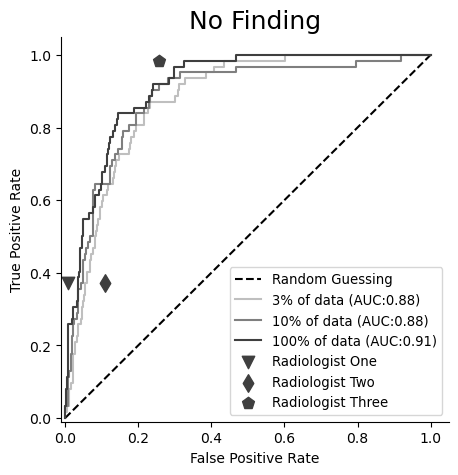

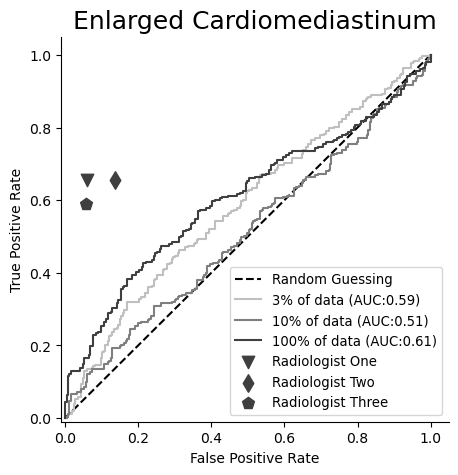

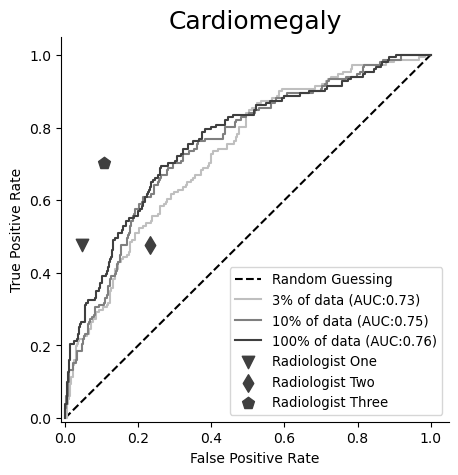

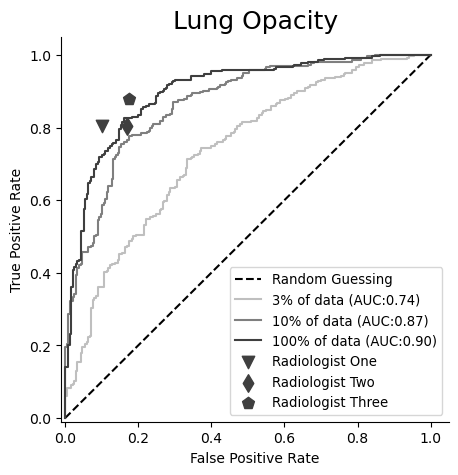

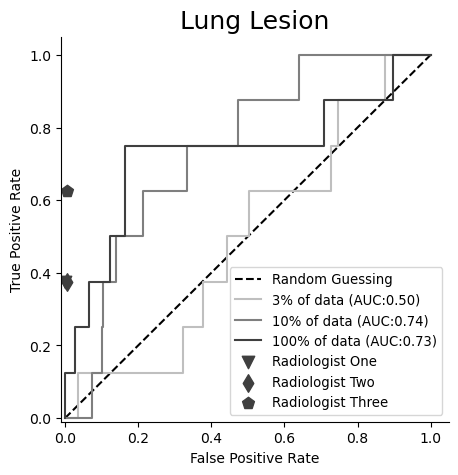

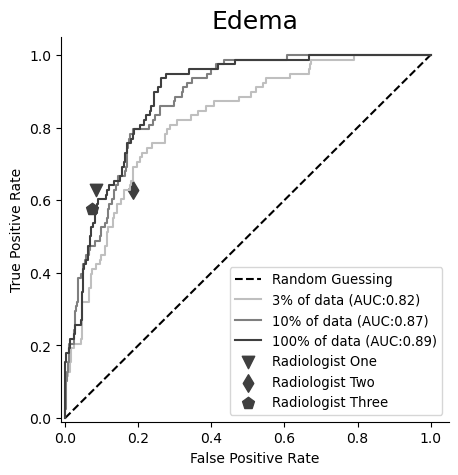

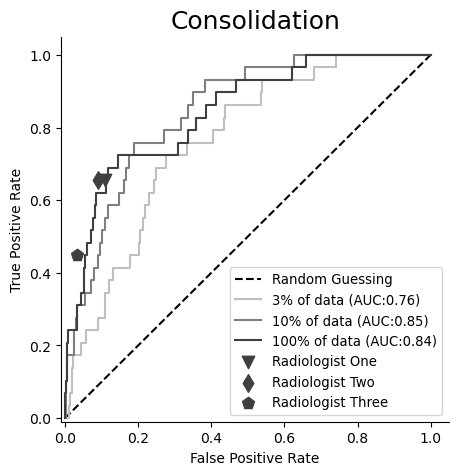

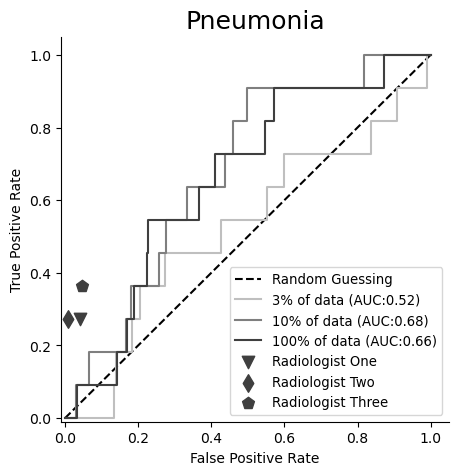

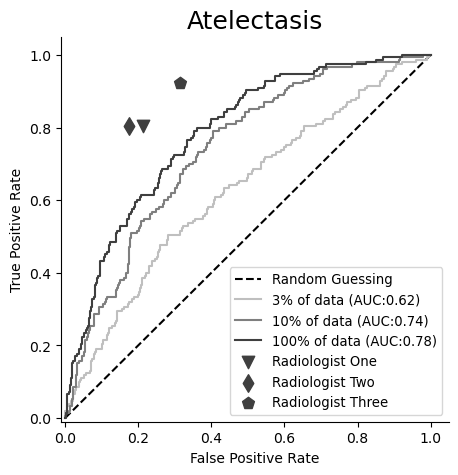

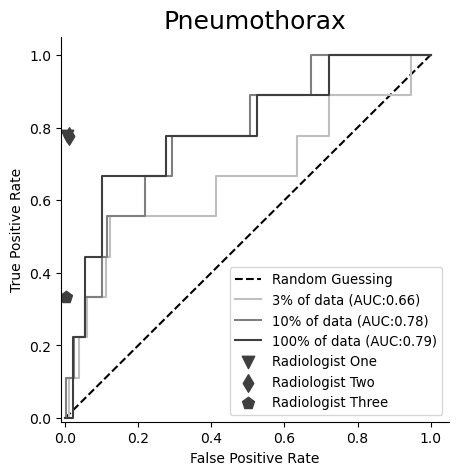

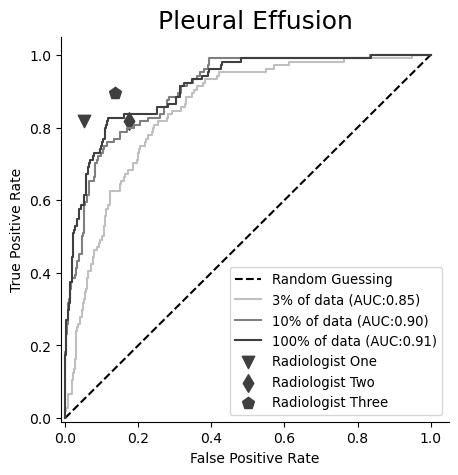

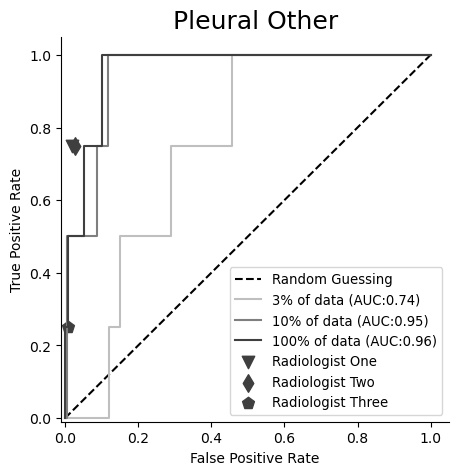

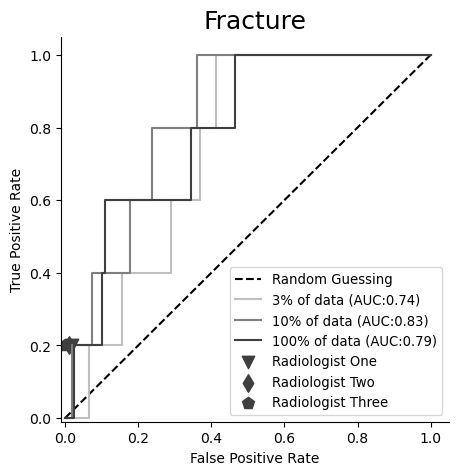

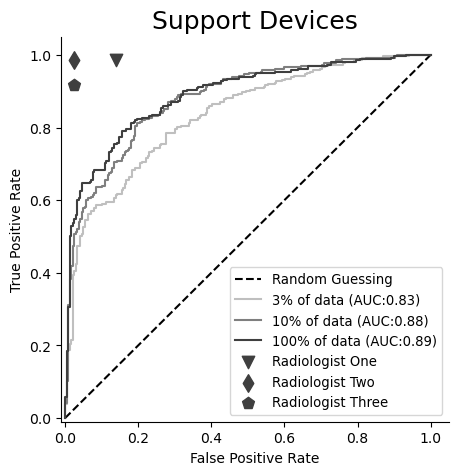

In [5]:
BasePath = '../diffae/checkpoints/chexpert256_autoenc_cls_best/'
y_true = np.load(os.path.join(BasePath, 'y_true.npy'))
y_pred_2 = np.load(os.path.join(BasePath, 'y_pred.npy'))
y_pred_0 = np.load(os.path.join('../diffae/checkpoints/unused/chexpert256_autoenc_cls_subsample_0.030000/', 'y_pred.npy'))
# y_pred_2 = np.load(os.path.join('../diffae/checkpoints/chexpert256_autoenc_cls_subsample_0.050000/', 'y_pred.npy'))
y_pred_1 = np.load(os.path.join('../diffae/checkpoints/chexpert256_autoenc_cls_subsample_0.100000/', 'y_pred.npy'))


averages = []
sequential_colors = sns.color_palette("gray_r", 3)
for i in range(len(PRED_LABEL)):
    # fpr, tpr, _ = roc_curve(y_true[:,i], y_pred[:,i])
    fpr_0, tpr_0, _ = roc_curve(y_true[:,i], y_pred_0[:,i])
    fpr_1, tpr_1, _ = roc_curve(y_true[:,i], y_pred_1[:,i])
    fpr_2, tpr_2, _ = roc_curve(y_true[:,i], y_pred_2[:,i])
    # fpr_3, tpr_3, _ = roc_curve(y_true[:,i], y_pred_3[:,i])
    
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
    _ = ax1.plot(fpr_0, fpr_0, 'k--', label = 'Random Guessing')
    
    _ = ax1.plot(fpr_0, tpr_0, color=sequential_colors[0], alpha = 1, 
                 label = '3%% of data (AUC:%2.2f)' % roc_auc_score(y_true[:,i], y_pred_0[:,i]))
    _ = ax1.plot(fpr_1, tpr_1, color=sequential_colors[1], alpha = 1, 
                 label = '10%% of data (AUC:%2.2f)' % roc_auc_score(y_true[:,i], y_pred_1[:,i]))
    _ = ax1.plot(fpr_2, tpr_2, color=sequential_colors[2], alpha = 1, 
                 label = '100%% of data (AUC:%2.2f)' % roc_auc_score(y_true[:,i], y_pred_2[:,i]))
    # _ = ax1.plot(fpr_3, tpr_3, color=sequential_colors[3], alpha = 1, 
    #              label = '(AUC:%2.2f)' % roc_auc_score(y_true[:,i], y_pred_3[:,i]))
    
    
    # averages.append(roc_auc_score(y_true[:,i], y_pred[:,i]))
    patho = PRED_LABEL[i]
    
    _ = ax1.scatter(x= bc4[patho][0], y=bc4[patho][1], s=80, marker='v', 
                    label='Radiologist One', color=sequential_colors[-1], alpha=1)
    _ = ax1.scatter(x= bc6[patho][0], y=bc4[patho][1], s=80, marker='d', 
                    label='Radiologist Two', color=sequential_colors[-1], alpha=1)
    _ = ax1.scatter(x= bc8[patho][0], y=bc8[patho][1], s=80, marker='p', 
                    label='Radiologist Three', color=sequential_colors[-1], alpha=1)

    _ = ax1.legend(loc = 4, prop={'size': 9.5})
    _ = ax1.set_title(PRED_LABEL[i], fontsize=18)
    _ = ax1.set_xlabel('False Positive Rate')
    _ = ax1.set_ylabel('True Positive Rate')
    _ = ax1.set_xlim([-0.01, 1.05])
    _ = ax1.set_ylim([-0.01, 1.05])
    _ = ax1.spines['top'].set_visible(False)
    _ = ax1.spines['right'].set_visible(False)
